In [1]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd

def get_all_experiment_and_run_ids():
    """
    MLflow에서 모든 experiment ID와 run ID를 조회하여 반환하는 함수
    
    Returns:
        pd.DataFrame: experiment_id, experiment_name, run_id, run_name 컬럼을 가진 DataFrame
    """
    client = MlflowClient()
    
    # 모든 실험 조회
    experiments = client.search_experiments()
    
    results = []
    
    for experiment in experiments:
        exp_id = experiment.experiment_id
        exp_name = experiment.name
        
        # 각 실험의 모든 run 조회
        runs = client.search_runs(experiment_ids=[exp_id])
        
        for run in runs:
            run_id = run.info.run_id
            run_name = run.data.tags.get("mlflow.runName", "")  # run name이 있으면 가져오기
            
            results.append({
                'experiment_id': exp_id,
                'experiment_name': exp_name,
                'run_id': run_id,
                'run_name': run_name,
                'status': run.info.status,
                'start_time': pd.to_datetime(run.info.start_time, unit='ms')
            })
    
    df = pd.DataFrame(results)
    
    # 결과 출력
    print(f"총 {len(df['experiment_id'].unique())}개의 실험에서 {len(df)}개의 run을 발견했습니다.")
    print("\n실험별 run 개수:")
    print(df.groupby(['experiment_id', 'experiment_name']).size().reset_index(name='run_count'))
    
    return df

In [2]:
# 함수 실행
df = get_all_experiment_and_run_ids()
print("\n전체 결과:")
display(df)
print(f"로드 완료: {len(df['experiment_id'].unique())}개 실험, {len(df)}개 run")

총 1개의 실험에서 3개의 run을 발견했습니다.

실험별 run 개수:
        experiment_id          experiment_name  run_count
0  926927982206685134  huggingface_cpu_example          3

전체 결과:


,experiment_id,experiment_name,run_id,run_name,status,start_time
0,926927982206685134,huggingface_cpu_example,af206b3e07ac489da3288d95ca0b0275,capable-auk-759,FINISHED,2025-07-14 14:02:12.262
1,926927982206685134,huggingface_cpu_example,5ea0f0d960cf4c0ca87dcd7cd859e147,adorable-dog-850,FAILED,2025-07-14 14:00:37.414
2,926927982206685134,huggingface_cpu_example,185943a87e634711972905ba2871dd81,adaptable-ape-998,FAILED,2025-07-14 14:00:16.427


로드 완료: 1개 실험, 3개 run


In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output
# Run 선택 위젯
run_selector = widgets.Dropdown(
    options=df['run_id'].values,
    description='Run 선택:',
    layout=widgets.Layout(width='700px'),
    style={'description_width': '80px'}
)

display(run_selector)

Dropdown(description='Run 선택:', layout=Layout(width='700px'), options=('af206b3e07ac489da3288d95ca0b0275', '5e…

In [4]:
selected_run_id = run_selector.value
client = MlflowClient()
run = client.get_run(selected_run_id)

In [5]:
metric_names =  [k for k,v in run.data.metrics.items()]

In [6]:
import ipywidgets as widgets
from IPython.display import display, clear_output
# Run 선택 위젯
run_selector2 = widgets.Dropdown(
    options=metric_names,
    description='Metric 선택:',
    layout=widgets.Layout(width='700px'),
    style={'description_width': '80px'}
)

display(run_selector2)

Dropdown(description='Metric 선택:', layout=Layout(width='700px'), options=('grad_norm', 'loss', 'epoch', 'learn…

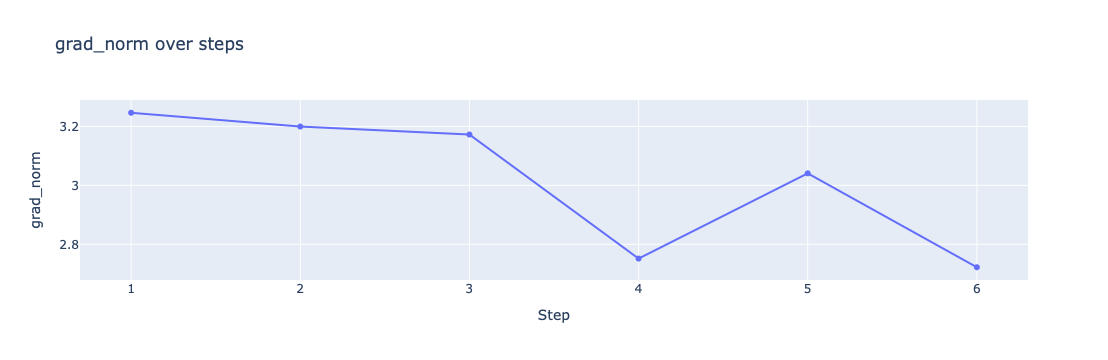

In [7]:
selected_metric_name = run_selector2.value
metric_history = client.get_metric_history(selected_run_id, selected_metric_name)

records = []
records.extend([
    {"step": m.step, "name": selected_metric_name, "value": m.value}
    for m in metric_history
])

df = pd.DataFrame(records)
import plotly.express as px
# Plotly Express로 한 줄에 라인 그래프 생성
fig = px.line(
    df, 
    x='step', 
    y='value',
    title=f'{selected_metric_name} over steps',
    labels={'step': 'Step', 'value': f'{selected_metric_name}'},
    markers=True
)

fig.show()